In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis

import random
import itertools

import os
from os import listdir
from os.path import isfile
import math

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec

import datetime
from tqdm import *
from datetime import *

import keras
from keras.applications import *
import lightgbm as lgbm

from scipy import ndimage
from scipy import misc
from scipy import signal
import cv2
plt.ion()
plt.show()

import keras

from keras.layers import Input, Dense, Lambda, Layer, Conv2D, MaxPooling2D,UpSampling2D, concatenate, Dropout,Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint


import collections
from collections import *

import tensorflow as tf
from IPython.display import clear_output
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


Using TensorFlow backend.


![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [ ]:
# !dir data/stage1_test

In [2]:
trainDir = 'data/stage1_train/'
testDir = 'data/stage1_test/'
unetSize = 128

In [3]:
fileIDs = listdir(trainDir)
testIDs = listdir(testDir)
len(testIDs)

65

In [5]:
def getFileImage(fileID, dd=trainDir):
    if not os.path.isfile(dd + fileID + '/images/'+ fileID + '.png'):
        print('Missing image file with ID %s' % fileID)
        return None
    else:
        return misc.imread(dd + fileID + '/images/'+fileID + '.png')

def drawContour(x):
    res = signal.convolve2d(x, [[1,1,1],[1,1,1],[1,1,1]], 'same')
    indices = np.where((res/255 < 9) & (x == 255)==True)
    x[indices[0],indices[1]] = 128
    return x

def getFileMasks(fileID):
    if not os.path.isdir(trainDir + fileID + '/masks/'):
        print('Missing image file with ID %s' % fileID)
        return None
    else:
        theMask = None
        for mask in listdir(trainDir + fileID + '/masks/'):
            m = misc.imread(trainDir + fileID + '/masks/' + mask)
            m = drawContour(m)
            if theMask is None:
                theMask = m
            else:
                theMask = theMask + m
        return theMask
        


In [6]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def imgResizeNormalizeAndGrayscale(img, newDimension, normalize = True, grayscale = True):

        
    # todo: check both dimensions, or either
    if img.shape[0] > newDimension[0]: 
        img = cv2.resize(img,newDimension, cv2.INTER_AREA)
    else:
        img = cv2.resize(img,newDimension, cv2.INTER_CUBIC)
        
    if normalize :
        img = cv2.normalize(img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F, dst=None)
    # convert image to grayscale only if it has 3 dimensions - it is not already grayscale
    if grayscale and len(img.shape) > 2 and img.shape[2] >= 3:
        img = rgb2gray(img)
    return img
    
# evaluateImage(40)

(256, 320, 4)


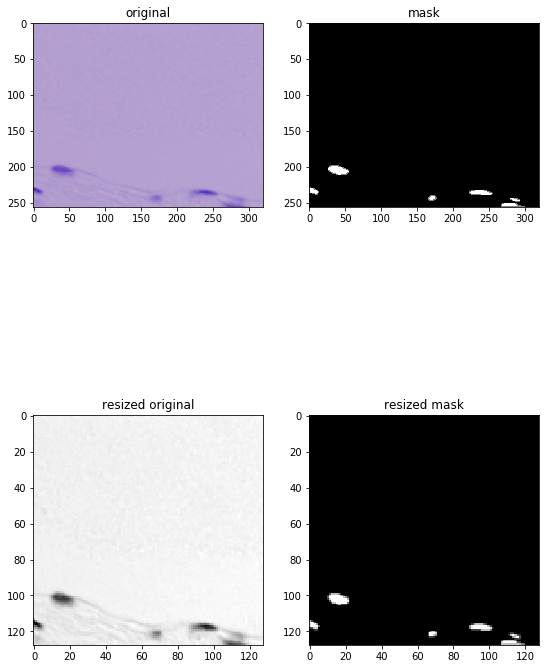

In [7]:

def evaluateImage(imageID, model=None):
    plt.figure(figsize=(14,14))

    img = getFileImage(fileIDs[imageID])

    print(img.shape)
    plt.subplot(231)
    plt.grid(False)
    plt.title('original')
    plt.imshow(img, cmap='gray')
    plt.subplot(234)
    plt.grid(False)
    plt.title('resized original')
    plt.imshow(imgResizeNormalizeAndGrayscale(img, (unetSize,unetSize)), cmap='gray')

    if model is not None:
        pred = model.predict(np.stack([imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize))])[:,:,:, newaxis])[0,:,:,0]
        print(pred.shape)
        plt.subplot(233)
        plt.grid(False)
        plt.title('prediction')
        plt.imshow(pred, cmap='gray')
        plt.subplot(236)
        plt.grid(False)
        plt.title('resized prediction')
        plt.imshow(imgResizeNormalizeAndGrayscale(pred, (unetSize,unetSize)), cmap='gray')
    
    img = getFileMasks(fileIDs[imageID])
    plt.subplot(232)
    plt.grid(False)
    plt.title('mask')
    plt.imshow(img, cmap='gray')
    plt.subplot(235)
    plt.grid(False)
    plt.title('resized mask')
    plt.imshow(imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize)), cmap='gray')
    


evaluateImage(40)
# evaluateImage(650, unetAE)

In [8]:
if os.path.isfile('data/inputImgGrayscaleNormalized128.npy'):
    inputImg = np.load('data/inputImgGrayscaleNormalized128.npy')
    masks = np.load('data/masksGrayscaleNormalized128.npy')
else:
    inputImg = []
    masks = []
    for fileId in fileIDs:
        print('.', end ='')
        inputImg.append(imgResizeNormalizeAndGrayscale(getFileImage(fileId), (unetSize, unetSize)))
        masks.append(imgResizeNormalizeAndGrayscale(getFileMasks(fileId), (unetSize, unetSize)))
    inputImg = np.stack(inputImg)
    inputImg = inputImg[:,:,:, newaxis]
    masks = np.stack(masks)
    masks = masks[:,:,:, newaxis]
    np.save('data/masksGrayscaleNormalized128.npy', masks)
    np.save('data/inputImgGrayscaleNormalized128.npy', inputImg)
    
    
    
masks.shape
inputImg.shape

(670, 128, 128, 1)

(670, 128, 128, 1)

In [10]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
#     print(lab_img.shape, lab_img.max() )
#     print(lab_img)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
        
        
        
def submit(testIDs, model):
    rles = []
    new_test_ids = []
    for fileID in testIDs:
        img = getFileImage(fileID, testDir)
        pred = model.predict(np.stack([imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize))])[:,:,:, newaxis])[0,:,:,0]
        pred = imgResizeNormalizeAndGrayscale(pred, (img.shape[1], img.shape[0]), False, False)
#         pred = np.round(imgResizeNormalizeAndGrayscale(pred, img.shape[:2], False, False) )
#         print('orig : ', img.shape, img.shape[:2], pred.shape)
        rle = list(prob_to_rles(pred))
        rles.extend(rle)
        new_test_ids.extend([fileID] * len(rle))
        # render prediction and original
        plt.figure()
        plt.subplot(121)
        plt.title('original')
        plt.imshow(img, cmap = 'gray')
        
        plt.title('prediction')
        plt.subplot(122)
        plt.imshow(pred, cmap = 'gray')
        
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

    return sub


# r = submit(testIDs, unetAE)
# r.head()
# submit(testIDs[:2], unetAE)

    
# cid = 1  
# print('test', inputImg[cid].shape)

# plt.imshow(inputImg[cid].reshape(inputImg[cid].shape[:2]))
# plt.figure()
# plt.imshow(masks[cid].reshape(masks[cid].shape[:2]))
# plt.show()

# rle = list(prob_to_rles(masks[cid]))
# print(len(rle))
# rle


In [ ]:
# !rm data/*.npy

## U net

![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [12]:

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        
    def on_train_begin(self, logs={}):
        self.initVars()

    def on_epoch_end(self, epoch, logs={}):
        self.i += 1
        
        print('bi = ', i)
        clear_output(wait=True)
        print('i = ', i)
#         if self.i% 5 != 0:
#             return
        
        # make a prediction
        testIdx = random.randint(0, len(testIDs)-1)
        img = getFileImage(testIDs[testIdx], testDir)
        plt.figure(figsize=(10,8))
        plt.subplot(221)
        plt.grid(False)
        plt.title('original')
        plt.imshow(img, cmap='gray')
        
        pred = unetAE.predict(np.stack([imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize))])[:,:,:, newaxis])[0,:,:,0]
        plt.subplot(222)
        plt.grid(False)
        plt.title('prediction')
        plt.imshow(pred, cmap='gray')
        
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
        self.x.append(self.i)
        
        plt.subplot(223)
        plt.plot(np.arange(len(self.losses)), self.losses, label="train loss")
        plt.plot(np.arange(len(self.losses)), self.val_losses, label="val loss")

        plt.legend()
        plt.show();

        
myPlotLosses = PlotLosses()
myPlotLosses.initVars();

In [16]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [17]:
imgsize = unetSize

def uconvx2(x, channels):
#     x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
#     x = Dropout(0.1) (x)
#     x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
    x = Conv2D(channels, (3,3), activation='relu', padding='same')(x)
    x = Dropout(0.1) (x)
    x = Conv2D(channels, (3,3), activation='relu', padding='same')(x)
    return x

def uConvDown(x, channels):
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = uconvx2(x, channels)
    return x

def uConvUp(x, grey, channels):
    x = UpSampling2D((2, 2))(x)
    x = uconvx2(concatenate([x,grey]), channels)
    return x

inp = Input(shape=(imgsize,imgsize,1), name='input')

startChannel = 8
numChannels = 4
layer = []

layer.append(uconvx2(inp, startChannel))
for i in range(1, numChannels+1):
    layer.append(uConvDown(layer[-1],startChannel*(2**i)))

middle = layer[-1]

for i in range(numChannels+1,1,-1):
    layer.append(uConvUp(layer[-1], layer[i-2], startChannel*(2**i)))

out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(layer[-1])


mid = Model(inp, middle)
unetAE = Model(inp,out)
unetAE.compile(optimizer='adam', loss= bce_dice_loss,  metrics=[mean_iou])
# unetAE.compile(optimizer='adam', loss='binary_crossentropy')
# unetAE.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

unetAE.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
conv2d_39 (Conv2D)               (None, 128, 128, 8)   80          input[0][0]                      
____________________________________________________________________________________________________
dropout_19 (Dropout)             (None, 128, 128, 8)   0           conv2d_39[0][0]                  
____________________________________________________________________________________________________
conv2d_40 (Conv2D)               (None, 128, 128, 8)   584         dropout_19[0][0]                 
___________________________________________________________________________________________

i =  2


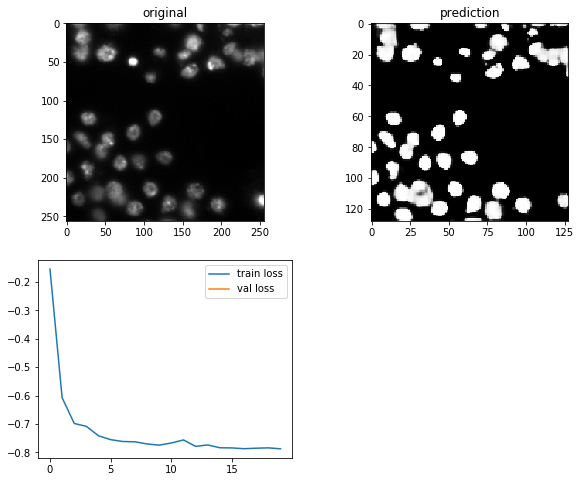

670/670 [==============================] - 3s - loss: -0.7879 - mean_iou: 0.7962     


In [18]:
batchSize = 4
# for i in range(0, len(inputImg), 20) :
#     x_train = inputImg[i: (i + 20)][:,:,:,:3]/255.0
#     y_train = masks[i: (i + 20)]/255.0
#     unetAE.fit(x_train, y_train,

earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('data/model1.h5', verbose=1, save_best_only=True)
unetAE.fit(inputImg, masks, epochs=20, batch_size=batchSize, shuffle=True, verbose=1 
           ,callbacks=[myPlotLosses, checkpointer]
#                 validation_data=(x_test, x_test),
              )

In [ ]:
unetAE.save('data/pc_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('data/pc_model.h5')

In [ ]:
evaluateImage(650, unetAE)

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


,ImageId,EncodedPixels
0,17b9bf4356db24967c4677b8376ac38f826de73a88b93a...,1 134 513 134 1025 134 1537 136 2049 137 2561 ...
1,17b9bf4356db24967c4677b8376ac38f826de73a88b93a...,101377 3 101889 5 102401 6 102913 7 103425 7 1...
2,17b9bf4356db24967c4677b8376ac38f826de73a88b93a...,169505 7 170015 10 170526 12 171038 13 171549 ...
3,17b9bf4356db24967c4677b8376ac38f826de73a88b93a...,54868 11 55378 16 55891 15 56404 14 56916 13 5...
4,17b9bf4356db24967c4677b8376ac38f826de73a88b93a...,130681 3 131191 7 131702 9 132213 10 132725 10...


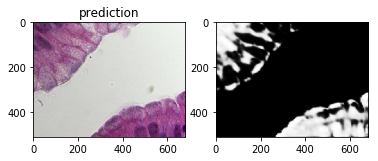

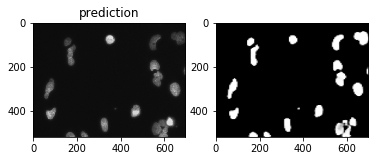

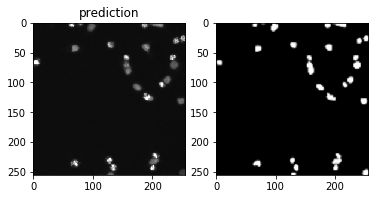

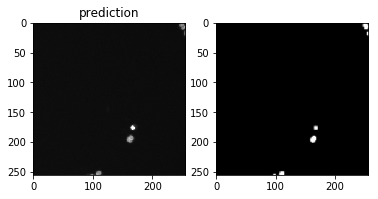

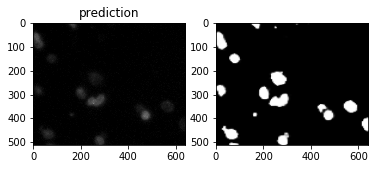

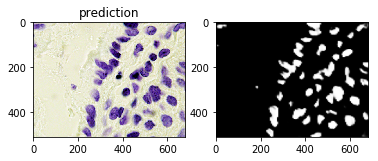

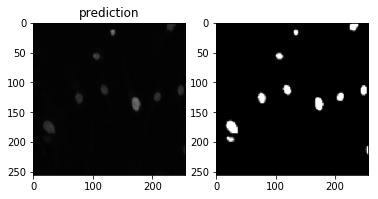

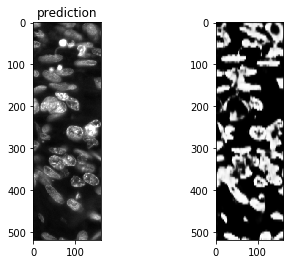

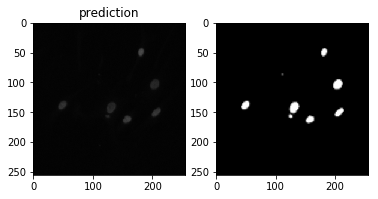

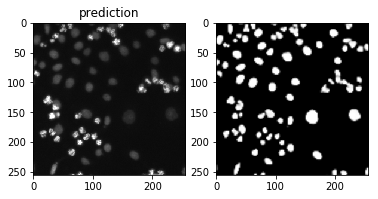

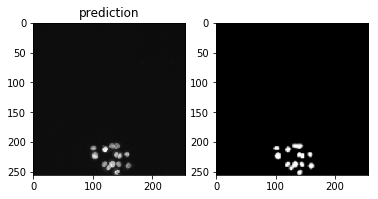

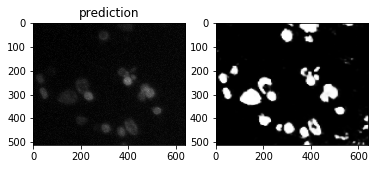

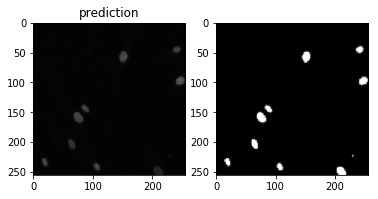

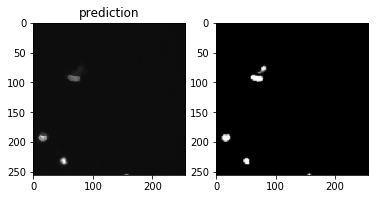

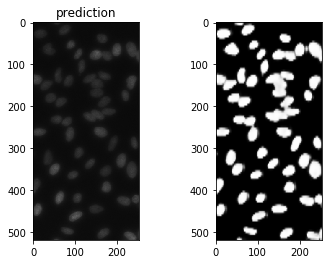

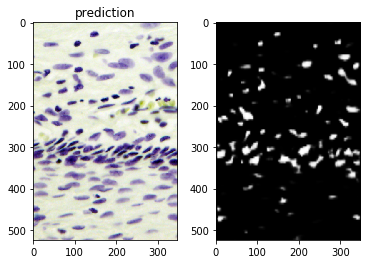

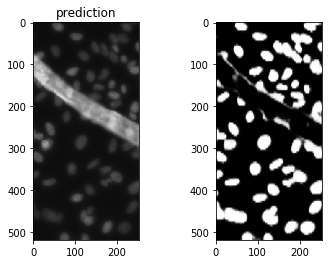

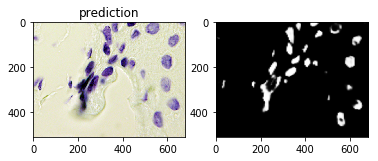

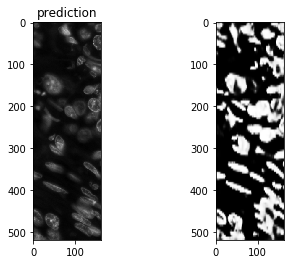

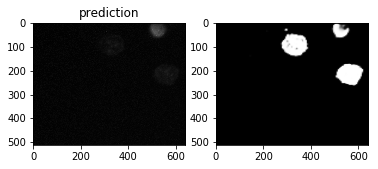

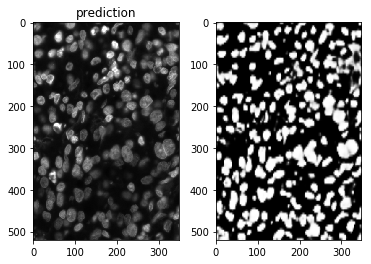

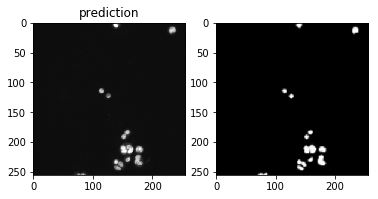

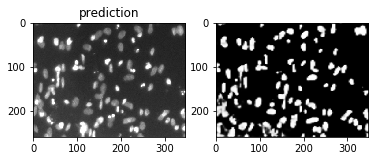

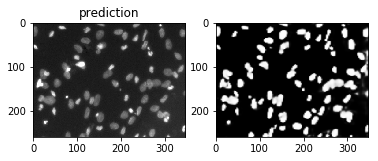

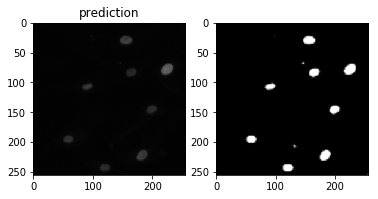

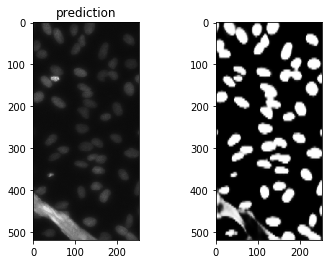

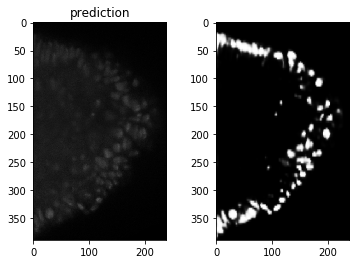

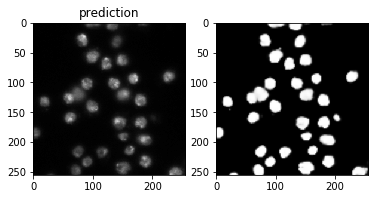

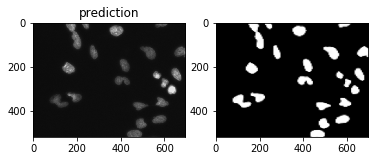

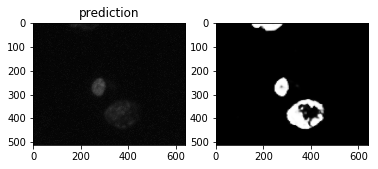

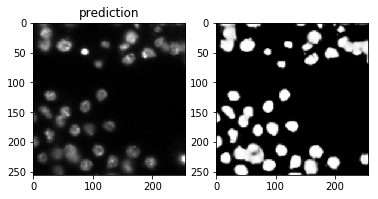

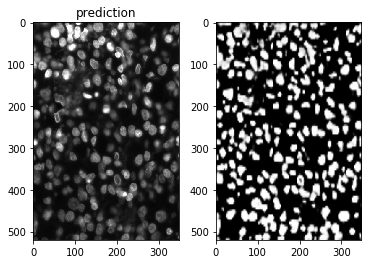

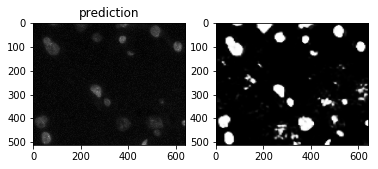

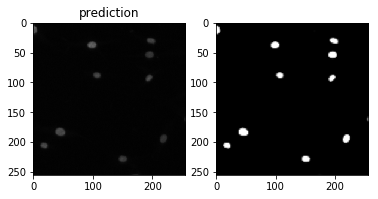

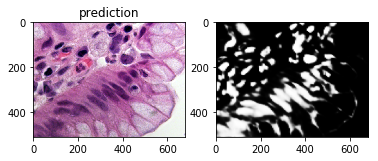

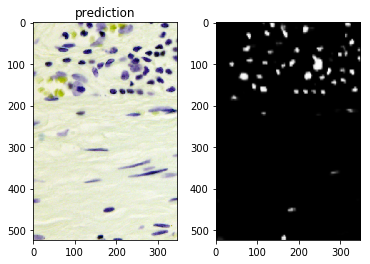

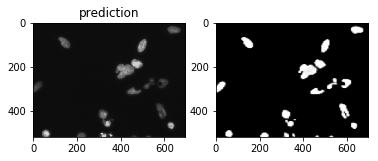

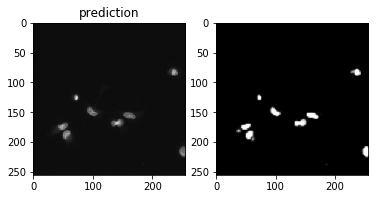

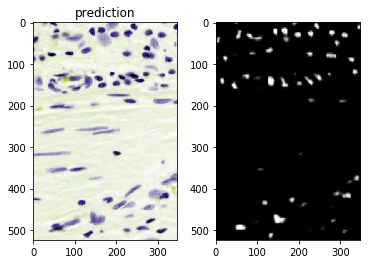

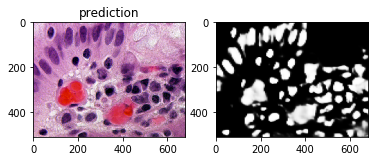

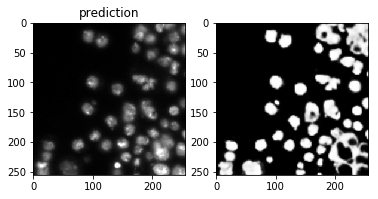

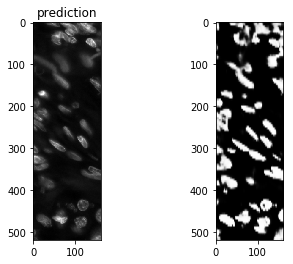

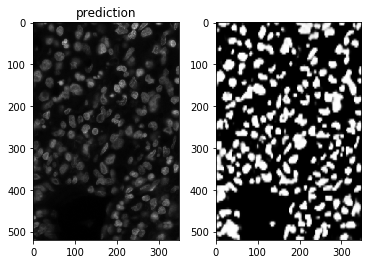

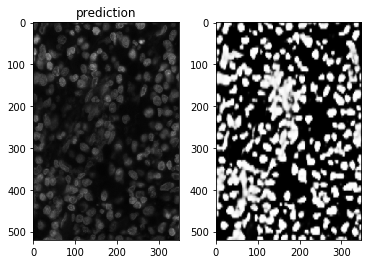

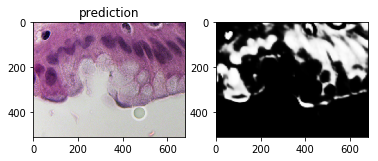

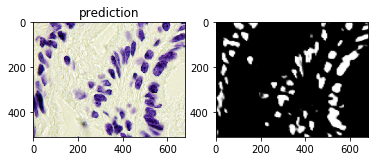

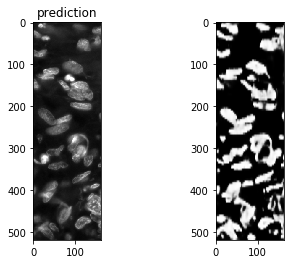

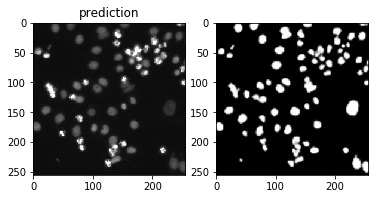

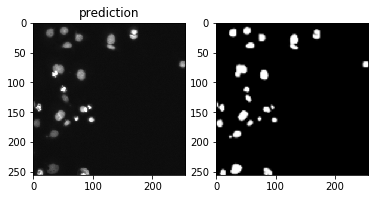

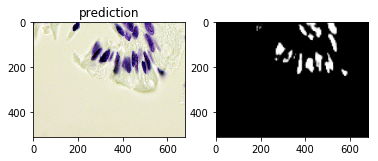

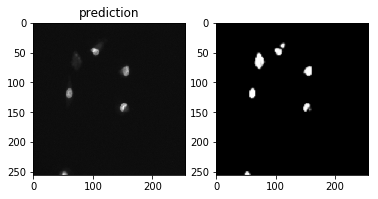

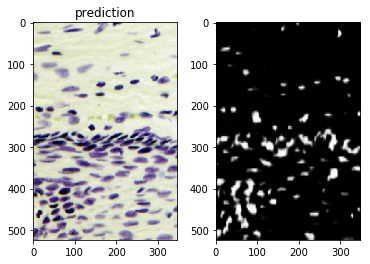

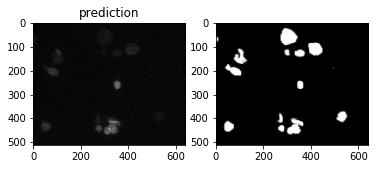

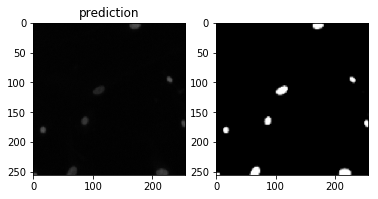

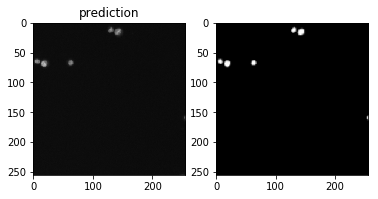

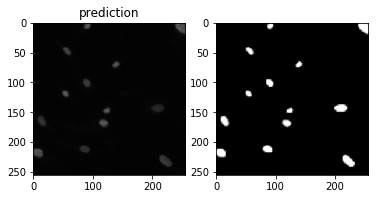

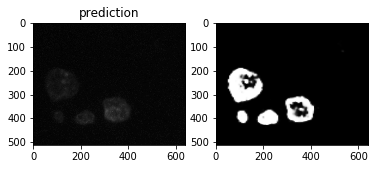

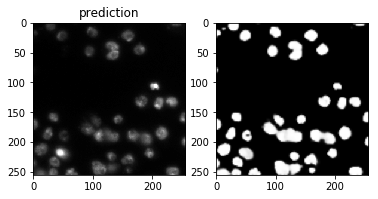

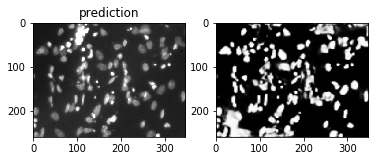

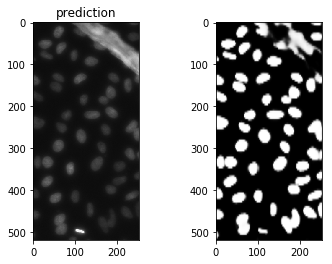

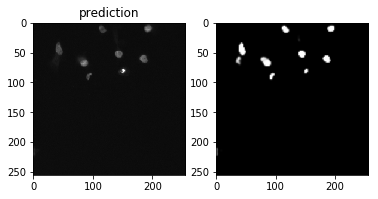

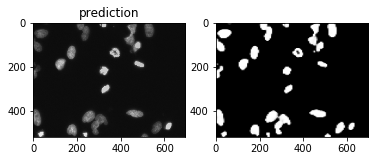

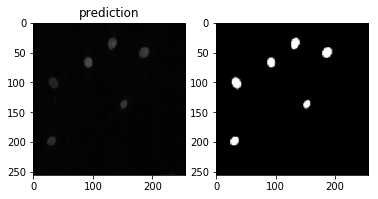

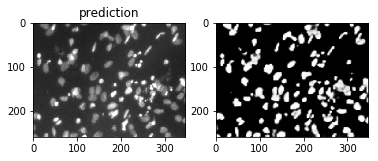

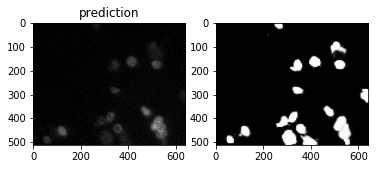

In [19]:
r = submit(testIDs, unetAE)
r.head()

In [20]:
# Write to file
filename = 'data/submission' + datetime.now().strftime('%Y-%m-%d_%H-%M')+ '.csv'
r.to_csv(filename, index=False)

In [ ]:
r.shape
len(testIDs)
# r.head()
len(r['ImageId'].unique())